# Plotting Template Matching Results

This notebook goes over the plots used in Figure 1 which visualizes 2DTM results over three different reference templates: the 60S large ribosomal subunit, the 40S small ribosomal subunit, and the proteasome.
The configuration files, scripts, and processed data for each of these template matching runs can be found here ((TODO)).

In [1]:
import mrcfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

plt.rcParams["figure.dpi"] = 120  # Increased the figure resolution

### Downloading Example Data

The following function downloads the remotely-hosted file urls into the same directory as this notebook.
We download data and results for the 60S, 40S, and 20S proteasome.

In [2]:
# TODO: Upload these data and make downloadable links
#       These are hard-links for now...
# fmt: off
img_60S_path = "/data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_252_000_0.0_DWS.mrc"
img_40S_path = "/data/papers/Leopard-EM_paper_data/xe30kv/all_mgraphs/xenon_252_000_0.0_DWS.mrc"
img_proteasome_path = "150_Mar12_12.28.45_165_0.mrc"

zscore_60S_path = "/data/papers/Leopard-EM_paper_data/xe30kv/results_match_tm_60S/xenon_252_000_0_output_scaled_mip.mrc"
zscore_40S_path = "/data/papers/Leopard-EM_paper_data/xe30kv/results_match_tm_40S-body/xenon_252_000_0_output_scaled_mip.mrc"
zscore_proteasome_path = "150_Mar12_output_scaled_mip.mrc"

# Open each of the paths
img_60S             = mrcfile.open(img_60S_path, mode="r").data.copy()
img_40S             = mrcfile.open(img_40S_path, mode="r").data.copy()
img_proteasome      = mrcfile.open(img_proteasome_path, mode="r").data[0].copy()
zscore_60S          = mrcfile.open(zscore_60S_path, mode="r").data.copy()
zscore_40S          = mrcfile.open(zscore_40S_path, mode="r").data.copy()
zscore_proteasome   = mrcfile.open(zscore_proteasome_path, mode="r").data.copy()
# fmt: on

# Print the shapes of the images
print(f"Shape of 60S image:         {img_60S.shape}")
print(f"Shape of 40S image:         {img_40S.shape}")
print(f"Shape of Proteasome image:  {img_proteasome.shape}")
print(f"Shape of 60S zscore:        {zscore_60S.shape}")
print(f"Shape of 40S zscore:        {zscore_40S.shape}")
print(f"Shape of Proteasome zscore: {zscore_proteasome.shape}")

Shape of 60S image:         (4096, 4096)
Shape of 40S image:         (4096, 4096)
Shape of Proteasome image:  (4092, 5760)
Shape of 60S zscore:        (3585, 3585)
Shape of 40S zscore:        (3585, 3585)
Shape of Proteasome zscore: (3709, 5377)


### Functions to generate the types of 2D and 3D plots

In [3]:
def plot_zscore_2D(
    fig,
    ax,
    x_region: tuple[int, int],
    y_region: tuple[int, int],
    pixel_size: float,
    zscore: np.ndarray,
    cmap: str,
    vmin: float = None,
    vmax: float = None,
    colorbar: bool = True,
):
    """
    Plot a 2D z-score image.

    Parameters:
        fig: The figure object.
        ax: The axes object to plot on.
        zscore: The z-score data to plot.
        cmap: The colormap to use for the plot.
        vmin: Minimum value for color scaling.
        vmax: Maximum value for color scaling.
    """
    extent = (
        x_region[0] * pixel_size,
        x_region[1] * pixel_size,
        y_region[0] * pixel_size,
        y_region[1] * pixel_size,
    )
    im = ax.imshow(
        zscore[y_region[0] : y_region[1], x_region[0] : x_region[1]],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        interpolation="nearest",
        origin="lower",
    )

    # Add colorbar if specified
    if colorbar:
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("z-score", labelpad=5)

    return

In [4]:
def plot_zscore_3D_mesh(
    fig,
    ax,
    x_region: tuple[int, int],
    y_region: tuple[int, int],
    pixel_size: float,
    zscore: np.ndarray,
    vmin: float = None,
    vmax: float = None,
    cmap: str = "viridis",
    alpha: float = 0.8,
    maintain_aspect: bool = True,
):
    """
    Plot a 3D mesh plot of z-score data with proper rectangular region handling.

    Parameters:
        fig: The figure object.
        ax: The 3D axes object to plot on.
        x_region: tuple of (x_start, x_end) for region of interest
        y_region: tuple of (y_start, y_end) for region of interest
        pixel_size: pixel size in physical units
        zscore: The z-score data to plot.
        cmap: The colormap to use for the plot.
        alpha: Transparency of the mesh
        maintain_aspect: Whether to maintain aspect ratio of the rectangular region
    """
    # Extract the region of interest
    roi = zscore[y_region[0] : y_region[1], x_region[0] : x_region[1]]
    
    # Create coordinate grids with actual physical coordinates
    x_coords = np.linspace(x_region[0] * pixel_size, x_region[1] * pixel_size, roi.shape[1])
    y_coords = np.linspace(y_region[0] * pixel_size, y_region[1] * pixel_size, roi.shape[0])
    X, Y = np.meshgrid(x_coords, y_coords)

    # Create 3D mesh plot
    surf = ax.plot_surface(X, Y, roi, cmap=cmap, alpha=alpha, linewidth=0, antialiased=True)

    # Set labels
    ax.set_xlabel("x pos (Å)")
    ax.set_ylabel("y pos (Å)")
    ax.set_zlabel("z-score")

    # Set limits for all axes to maintain proper scaling
    ax.set_xlim(x_region[0] * pixel_size, x_region[1] * pixel_size)
    ax.set_ylim(y_region[0] * pixel_size, y_region[1] * pixel_size)
    
    if vmin is not None and vmax is not None:
        ax.set_zlim(vmin, vmax)

    # Maintain aspect ratio if requested
    if maintain_aspect:
        # Calculate the actual dimensions
        x_range = (x_region[1] - x_region[0]) * pixel_size
        y_range = (y_region[1] - y_region[0]) * pixel_size
        
        # Set aspect ratio to be equal for x and y
        ax.set_box_aspect([x_range, y_range, max(x_range, y_range) * 0.5])

    return surf

### Defining constants

In [5]:
pixel_size = 0.936  # Angstroms per pixel
# pixel_size = 1  # For region testing

# # Set of regions A
# x1_region = (1000, 2000)  # Larger ROI
# y1_region = (1000, 2000)

# # x2_region = (1475, 1575)  # Smaller square sub-region
# # y2_region = (1435, 1535

# x2_region = (1475, 1575)  # Smaller rectangular sub-region including 2 peaks
# y2_region = (1435, 1700)

# Set of regions B
x1_region = (100, 780)  # Larger ROI
y1_region = (600, 1280)

# x2_region = (1475, 1575)  # Smaller square sub-region
# y2_region = (1435, 1535

x2_region = (170, 450)  # Smaller rectangular sub-region including 2 peaks
y2_region = (850, 1050)


cmap_2D = "hot"  # Hot seems to still accentuate smaller features
cmap_3D = "turbo"

print("Region shape:                 ", (y1_region[1] - y1_region[0], x1_region[1] - x1_region[0]))
print("Region shape (Angstroms):     ", ((y1_region[1] - y1_region[0]) * pixel_size, (x1_region[1] - x1_region[0]) * pixel_size))
print("Sub-region shape:             ", (y2_region[1] - y2_region[0], x2_region[1] - x2_region[0]))
print("Sub-region shape (Angstroms): ", ((y2_region[1] - y2_region[0]) * pixel_size, (x2_region[1] - x2_region[0]) * pixel_size))

Region shape:                  (680, 680)
Region shape (Angstroms):      (636.48, 636.48)
Sub-region shape:              (200, 280)
Sub-region shape (Angstroms):  (187.20000000000002, 262.08000000000004)


In [6]:
# Find the vmin and vmax for both regions of the 60S and 40S z-scores in region
# Allows same color scale for both the 40S and 60S plots
vmin_60S = np.min(zscore_60S[y1_region[0] : y1_region[1], x1_region[0] : x1_region[1]])
vmax_60S = np.max(zscore_60S[y1_region[0] : y1_region[1], x1_region[0] : x1_region[1]])
vmin_40S = np.min(zscore_40S[y1_region[0] : y1_region[1], x1_region[0] : x1_region[1]])
vmax_40S = np.max(zscore_40S[y1_region[0] : y1_region[1], x1_region[0] : x1_region[1]])
vmin = min(vmin_60S, vmin_40S)
vmax = max(vmax_60S, vmax_40S)
vmin, vmax

(np.float32(4.725811), np.float32(15.666674))

### 2D z-score plots

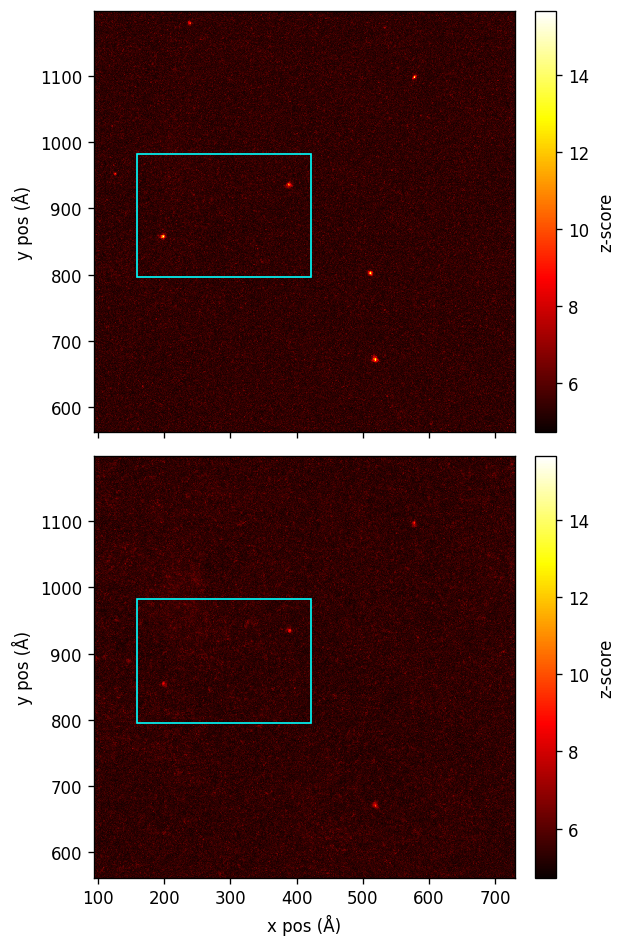

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
cmap_2D = "hot"  # Hot seems to still accentuate smaller features

plot_zscore_2D(
    fig,
    ax[0],
    x1_region,
    y1_region,
    pixel_size,
    zscore_60S,  # 60S z-score array
    cmap=cmap_2D,
    vmin=vmin,
    vmax=vmax,
)
plot_zscore_2D(
    fig,
    ax[1],
    x1_region,
    y1_region,
    pixel_size,
    zscore_40S,  # 40S z-score array
    cmap=cmap_2D,
    vmin=vmin,
    vmax=vmax,
)

# Add bounding boxes for region 2 on both plots
rect_60S = plt.Rectangle(
    (x2_region[0] * pixel_size, y2_region[0] * pixel_size),
    (x2_region[1] - x2_region[0]) * pixel_size,
    (y2_region[1] - y2_region[0]) * pixel_size,
    linewidth=1,
    edgecolor="cyan",
    facecolor="none",
)
ax[0].add_patch(rect_60S)

rect_40S = plt.Rectangle(
    (x2_region[0] * pixel_size, y2_region[0] * pixel_size),
    (x2_region[1] - x2_region[0]) * pixel_size,
    (y2_region[1] - y2_region[0]) * pixel_size,
    linewidth=1,
    edgecolor="cyan",
    facecolor="none",
)
ax[1].add_patch(rect_40S)

# Setting the labels
# ax[0].set_xlabel("x pos (Å)")
ax[0].set_ylabel("y pos (Å)")
ax[1].set_xlabel("x pos (Å)")
ax[1].set_ylabel("y pos (Å)")


plt.tight_layout()

plt.savefig("01_xenon_252_000_0.0_DWS_zscore_60S_40S_plus_roi.pdf")

plt.show()

In [8]:
# Reset the vimin and vmax in the second region for the 3D plots
# Allows same color scale for both the 40S and 60S plots
vmin_60S = np.min(zscore_60S[y2_region[0] : y2_region[1], x2_region[0] : x2_region[1]])
vmax_60S = np.max(zscore_60S[y2_region[0] : y2_region[1], x2_region[0] : x2_region[1]])
vmin_40S = np.min(zscore_40S[y2_region[0] : y2_region[1], x2_region[0] : x2_region[1]])
vmax_40S = np.max(zscore_40S[y2_region[0] : y2_region[1], x2_region[0] : x2_region[1]])
vmin = min(vmin_60S, vmin_40S)
vmax = max(vmax_60S, vmax_40S)
vmin, vmax

(np.float32(4.7389684), np.float32(14.733342))

### 3D mesh plots of z-scores in small regions

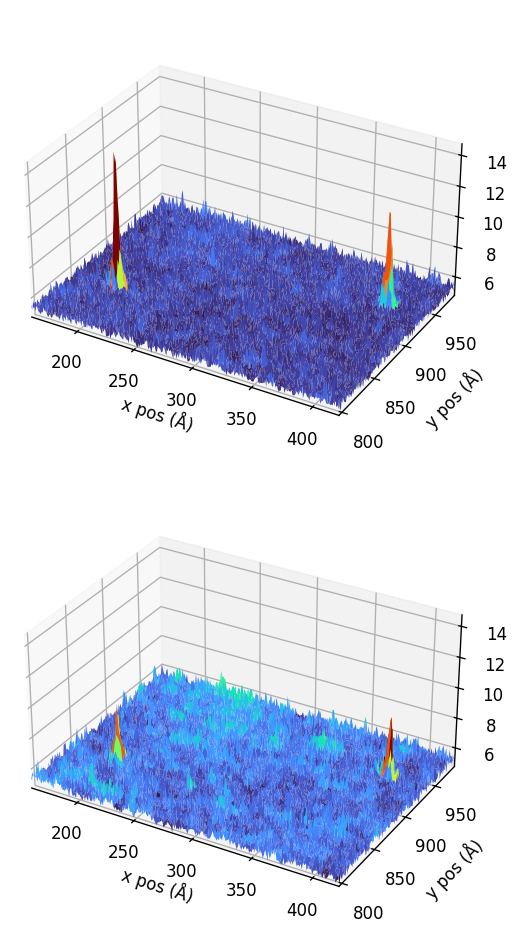

In [ ]:
# Create a 3D plot for the z-scores of 60S and 40S
fig, ax = plt.subplots(2, 1, figsize=(5, 8), subplot_kw={"projection": "3d"})
cmap_3D = "turbo"

plot_zscore_3D_mesh(
    fig,
    ax[0],
    x2_region,
    y2_region,
    pixel_size,
    zscore_60S,
    alpha=1.0,
    cmap=cmap_3D,
    vmin=vmin,
    vmax=vmax,
)
plot_zscore_3D_mesh(
    fig,
    ax[1],
    x2_region,
    y2_region,
    pixel_size,
    zscore_40S,
    alpha=1.0,
    cmap=cmap_3D,
    vmin=vmin,
    vmax=vmax,
)

# Reduce the number of y-tick marks on both 3D axes
for axis in ax:
    axis.locator_params(axis="y", nbins=4)

plt.tight_layout()

plt.savefig("01_xenon_252_000_0.0_DWS_zscore_60S_40S_roi_mesh.pdf")

plt.show()

## Proteasome Plot

In [10]:
pixel_size = 1.06  # Angstroms per pixel
# pixel_size = 1  # For region testing


# x3_region = (3420, 3920)
# y3_region = (1865, 2365)

# Calculate current center
center_x = (3420 + 3920) // 2
center_y = (1865 + 2365) // 2

# Create new 800x800 region centered on the same point
x3_region = (center_x - 300, center_x + 300)
y3_region = (center_y - 300, center_y + 300)

# Smaller sub-region for proteasome
x4_region = (3620, 3720)
y4_region = (2065, 2165)

# print region shape
print(f"Region shape:                 {y3_region[1] - y3_region[0]} x {x3_region[1] - x3_region[0]}")
print(f"Region shape (Angstroms):     {(y3_region[1] - y3_region[0]) * pixel_size} x {(x3_region[1] - x3_region[0]) * pixel_size}")
print(f"Sub-region shape:             {y4_region[1] - y4_region[0]} x {x4_region[1] - x4_region[0]}")
print(f"Sub-region shape (Angstroms): {(y4_region[1] - y4_region[0]) * pixel_size} x {(x4_region[1] - x4_region[0]) * pixel_size}")

Region shape:                 600 x 600
Region shape (Angstroms):     636.0 x 636.0
Sub-region shape:             100 x 100
Sub-region shape (Angstroms): 106.0 x 106.0


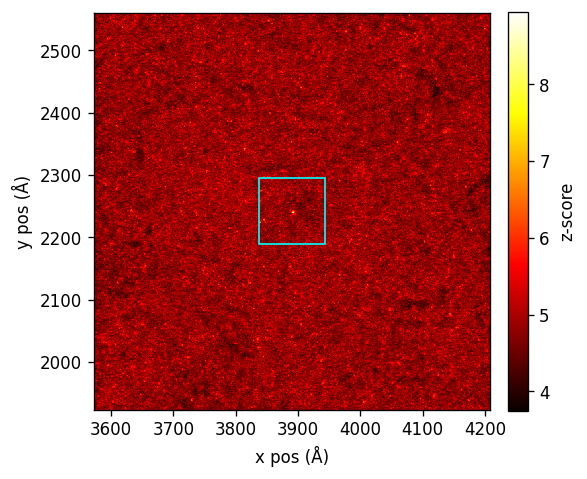

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
cmap_2D = "hot"  # Hot seems to still accentuate smaller features

plot_zscore_2D(
    fig,
    ax,
    x3_region,
    y3_region,
    pixel_size,
    zscore_proteasome,  # Proteasome z-score array
    cmap=cmap_2D,
    # vmin=vmin,
    # vmax=vmax,
)

rect_proteasome = plt.Rectangle(
    (x4_region[0] * pixel_size, y4_region[0] * pixel_size),
    (x4_region[1] - x4_region[0]) * pixel_size,
    (y4_region[1] - y4_region[0]) * pixel_size,
    linewidth=1,
    edgecolor="cyan",
    facecolor="none",
)
ax.add_patch(rect_proteasome)

# Setting the labels
ax.set_xlabel("x pos (Å)")
ax.set_ylabel("y pos (Å)")

plt.tight_layout()

plt.savefig("01_proteasome_zscore_region.pdf")

plt.show()

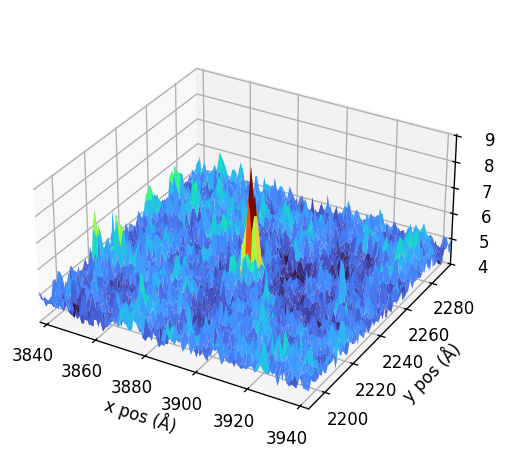

In [ ]:
# Create a 3D plot for the z-scores of 60S and 40S
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={"projection": "3d"})
cmap_3D = "turbo"

plot_zscore_3D_mesh(
    fig,
    ax,
    x4_region,
    y4_region,
    pixel_size,
    zscore_proteasome,
    alpha=1.0,
    cmap=cmap_3D,
)

# Reduce the number of x-tick and y-tick marks
ax.locator_params(axis="x", nbins=6)
ax.locator_params(axis="y", nbins=6)

plt.tight_layout()

plt.savefig("01_proteasome_zscore_region_mesh.pdf")

plt.show()

## Plots of original micrographs

### Low-pass helper functions

In [13]:
def butter_lowpass_image(
    data: np.ndarray,
    cutoff: float,
    fs: float,
    order: int = 5,
) -> np.ndarray:
    """
    Apply a Butterworth low-pass filter to a 2D image.
    Parameters:
        data: 2D numpy array representing the image.
        cutoff: Cutoff frequency for the low-pass filter.
        fs: Sampling frequency of the image.
        order: Order of the Butterworth filter.
    Returns:
        Filtered 2D numpy array.
    """

In [14]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift


def butterworth_lowpass_filter(shape, cutoff, order):
    """
    Generate a 2D Butterworth low-pass filter mask.

    Parameters:
        shape (tuple): Shape of the filter (rows, cols).
        cutoff (float): Cutoff frequency (0 to 0.5, relative to Nyquist).
        order (int): Order of the filter.

    Returns:
        H (2D np.array): Butterworth filter mask.
    """
    rows, cols = shape
    u = np.arange(-rows // 2, rows // 2)
    v = np.arange(-cols // 2, cols // 2)
    U, V = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    D = D / np.max(D)  # Normalize distance

    H = 1 / (1 + (D / cutoff) ** (2 * order))
    return H


def apply_butterworth_lowpass(image, cutoff=0.1, order=2):
    """
    Apply a 2D Butterworth low-pass filter to a grayscale image.

    Parameters:
        image (2D np.array): Input image.
        cutoff (float): Normalized cutoff frequency (0 to 0.5).
        order (int): Filter order.

    Returns:
        filtered (2D np.array): Filtered image.
    """
    image_fft = fft2(image)
    image_fft_shifted = fftshift(image_fft)

    H = butterworth_lowpass_filter(image.shape, cutoff, order)

    filtered_fft_shifted = image_fft_shifted * H
    filtered_fft = ifftshift(filtered_fft_shifted)
    filtered = np.real(ifft2(filtered_fft))

    return filtered

### Plot with bounding box helper function

In [29]:
def plot_filtered_image_with_bbox(
    fig,
    ax,
    image: np.ndarray,
    x_region: tuple[int, int],
    y_region: tuple[int, int],
    template_shape: tuple[int, int],
    pixel_size: float,
    title: str = None,
    cutoff: float = 0.1,
    order: int = 2,
    bbox_color: str = "black",
    bbox_linewidth: int = 1,
):
    """
    Plot a low-pass filtered image with a rectangular bounding box on a specified axes.
    
    Parameters:
        fig: The figure object
        ax: The axes object to plot on
        image: The input image array
        x_region: tuple of (x_start, x_end) for the region
        y_region: tuple of (y_start, y_end) for the region
        template_shape: tuple of (height, width) for template dimensions
        pixel_size: pixel size in physical units (Angstroms)
        title: Optional title for the plot
        cutoff: Cutoff frequency for Butterworth filter
        order: Order of the Butterworth filter
        bbox_color: Color of the bounding box
        bbox_linewidth: Line width of the bounding box
    """
    # Apply low-pass filter
    lp_img = apply_butterworth_lowpass(image, cutoff=cutoff, order=order)
    
    # Display the filtered image
    ax.imshow(
        lp_img,
        cmap="gray",
        extent=(
            0,
            lp_img.shape[1] * pixel_size,
            0,
            lp_img.shape[0] * pixel_size,
        ),
        origin="lower",
    )
    
    # Create rectangular bounding box
    rect = plt.Rectangle(
        (x_region[0] * pixel_size, y_region[0] * pixel_size),
        (x_region[1] - x_region[0] + template_shape[0]) * pixel_size,
        (y_region[1] - y_region[0] + template_shape[1]) * pixel_size,
        linewidth=bbox_linewidth,
        edgecolor=bbox_color,
        facecolor="none",
    )
    ax.add_patch(rect)
    
    # Set labels
    ax.set_xlabel("x pos (Å)")
    ax.set_ylabel("y pos (Å)")
    
    # Set title if provided
    if title:
        ax.set_title(title)
    
    return fig, ax

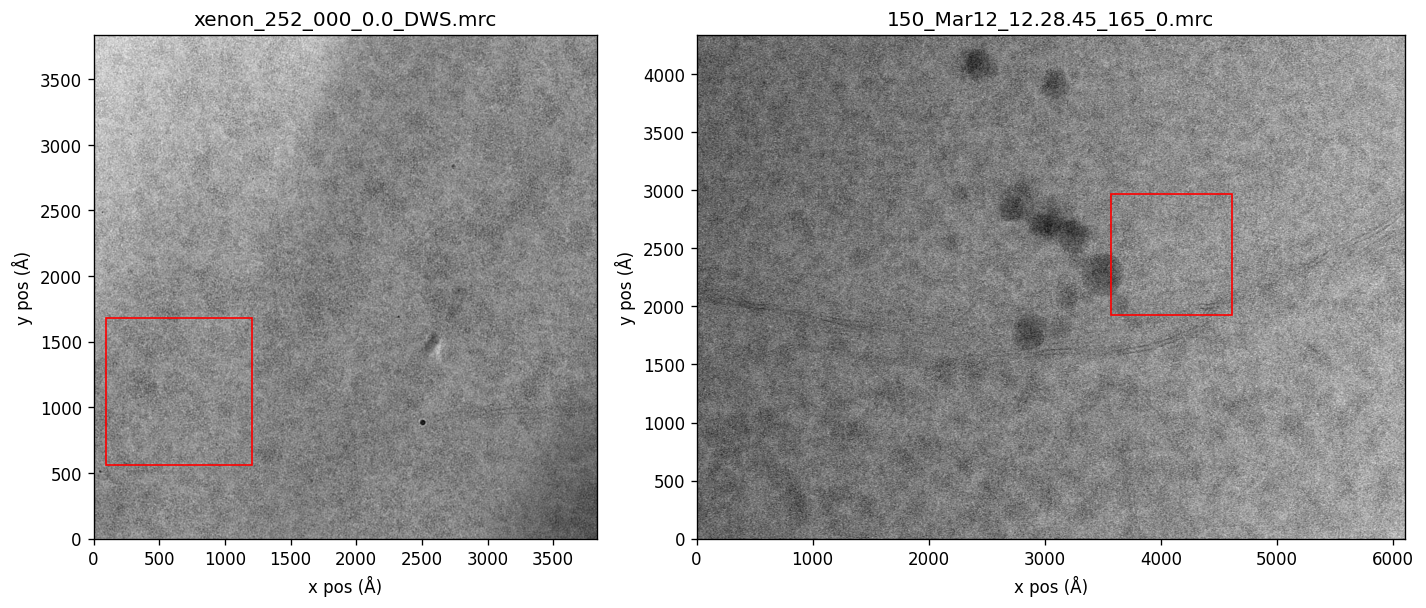

In [ ]:
# Calculate aspect ratios for both images
aspect_60S = img_60S.shape[0] / img_60S.shape[1]  # 4096/4096 = 1.0
aspect_proteasome = (
    img_proteasome.shape[0] / img_proteasome.shape[1]
)  # 4092/5760 ≈ 0.71

# Create subplots with width ratios that will make heights equal when displayed
# The proteasome image is wider, so we need to adjust the figure width ratios
width_ratios = [1.0, 1.0 / aspect_proteasome]
fig, ax = plt.subplots(
    1,
    2,
    figsize=(12, 5),
    gridspec_kw={"width_ratios": width_ratios},
)

# Plot for the original image to identify the 60S ribosome
template_shape = (512, 512)  # Shape for 60S and 40S ribosome templates
pixel_size = 0.936  # Angstroms per pixel

title_60S = img_60S_path.split("/")[-1]

plot_filtered_image_with_bbox(
    fig,
    ax[0],
    img_60S,
    x1_region,
    y1_region,
    template_shape,
    pixel_size,
    title=title_60S,
    cutoff=0.1,
    order=2,
    bbox_color="red",
    bbox_linewidth=1,
)

# Plot for the original image to identify the proteasome
template_shape = (384, 384)
pixel_size = 1.06
title_proteasome = img_proteasome_path.split("/")[-1]

plot_filtered_image_with_bbox(
    fig,
    ax[1],
    img_proteasome,
    x3_region,
    y3_region,
    template_shape,
    pixel_size,
    title=title_proteasome,
    cutoff=0.1,
    order=2,
    bbox_color="red",
    bbox_linewidth=1,
)

plt.tight_layout()

plt.savefig("01_original_micorgraphs_with_bboxes.pdf")

plt.show()